<h1>
All Available Variables, All Values, No Specific Target (Separate Morbidities)
</h1>

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx
from IPython.display import display
from pytetrad.tools.TetradSearch import TetradSearch
import pydot
import matplotlib.pyplot as plt
from graphviz import Source

BASE_DIR = Path().resolve()

In [2]:
df = pd.read_csv(BASE_DIR / 'data' / "natality_7yr_test_data_for_dag_3.csv")
df['date'] = pd.to_datetime(df['date'])

df

,date,dmar,ca_anen,ca_mnsb,ca_cchd,ca_cdh,ca_omph,ca_gast,ca_limb,ca_cleft,...,previs,pwgt_r,wtgain,rf_cesarn,combgest,dbwt,mager,fagecomb,smoking,hospital_birth_binary
0,2020-01-20,1,0,0,0,0,0,0,0,0,...,10.0,145.0,35.0,0.0,40.0,3570.0,25,30.0,0,1
1,2020-02-03,1,0,0,0,0,0,0,0,0,...,15.0,140.0,10.0,0.0,39.0,3560.0,28,27.0,0,1
2,2020-02-03,1,0,0,0,0,0,0,0,0,...,8.0,190.0,47.0,0.0,39.0,3130.0,36,35.0,0,1
3,2020-02-03,1,0,0,0,0,0,0,0,0,...,9.0,140.0,26.0,0.0,40.0,2760.0,32,34.0,0,1
4,2020-02-03,1,0,0,0,0,0,0,0,0,...,11.0,130.0,28.0,2.0,38.0,2948.0,39,44.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,2019-01-14,2,0,0,0,0,0,0,0,0,...,14.0,201.0,13.0,0.0,39.0,3345.0,19,22.0,0,1
209996,2019-01-14,2,0,0,0,0,0,0,0,0,...,12.0,130.0,25.0,0.0,39.0,4586.0,20,24.0,1,1
209997,2019-01-14,2,0,0,0,0,0,0,0,0,...,11.0,200.0,19.0,0.0,39.0,3240.0,28,29.0,0,1
209998,2019-01-14,2,0,0,0,0,0,0,0,0,...,7.0,130.0,62.0,0.0,35.0,1985.0,27,37.0,0,1


In [3]:
sampled = (
    df.groupby(df['date'].dt.year, group_keys=False)
      .apply(lambda g: g.sample(n=5000, random_state=42))
      .reset_index(drop=True)
)

In [4]:
continuous_cols_to_transform = [
    'bmi', 'time_sin', 'time_cos'
]

discrete_cols_to_transform  = [
    "precare", 'previs', 'pwgt_r', 'wtgain', 'rf_cesarn', 'combgest', 'dbwt',
    'mager', 'fagecomb'
]

Since most of our variables are one-hot / binary, we're going to convert them to bins so we can use one algorithm to generate & explore the DAG.

In [5]:
# We're dropping these because we have discrete versions of them, which might be more informative for the DAG.
binary_cols_to_drop = ["precare_binary"]
df_discrete = sampled.drop(columns=binary_cols_to_drop)

discretizer = KBinsDiscretizer(
    n_bins=4,
    encode='ordinal',
    strategy='uniform',
    quantile_method='averaged_inverted_cdf'
)

cols_to_transform = continuous_cols_to_transform + discrete_cols_to_transform

df_discrete[cols_to_transform] = discretizer.fit_transform(df_discrete[cols_to_transform])
df_discrete[cols_to_transform] = df_discrete[cols_to_transform].astype('int32')

constant_cols = [c for c in df_discrete.columns if c != 'date' and df_discrete[c].nunique() <= 1]
if constant_cols:
    print("Dropping constant columns:", constant_cols)
    df_discrete = df_discrete.drop(columns=constant_cols)

X = df_discrete.drop(columns=["date"]).astype(int)
names = df_discrete.drop(columns=["date"]).columns.tolist()

In [6]:
X.describe()

,dmar,ca_anen,ca_mnsb,ca_cchd,ca_cdh,ca_omph,ca_gast,ca_limb,ca_cleft,ca_clpal,...,previs,pwgt_r,wtgain,rf_cesarn,combgest,dbwt,mager,fagecomb,smoking,hospital_birth_binary
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,...,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,1.426657,0.000286,0.000171,0.000371,0.000171,0.000029,0.000400,0.000143,0.000600,0.000257,...,0.246429,0.715171,0.749429,0.047743,2.238857,1.401057,1.111114,0.767857,0.087171,0.972514
std,0.494599,0.016901,0.013092,0.019269,0.013092,0.005345,0.019996,0.011952,0.024488,0.016034,...,0.438496,0.696358,0.679894,0.227613,0.509157,0.540255,0.703895,0.540612,0.282090,0.163496
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000


<h2>PC Stable</h2>

In [7]:
searcher = TetradSearch(X)
searcher.add_to_tier(0, 'mracehisp')
searcher.add_to_tier(0, 'fracehisp')
searcher.add_to_tier(0, 'time_cos')
searcher.add_to_tier(0, 'time_sin')
searcher.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher.set_forbidden(v, 'time_sin')

In [ ]:
# Tests
searcher.use_g_square(alpha=0.05) # alpha=0.05

In [ ]:
searcher.run_pc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1}, 3={0=0, 1=1}, 4={0=0, 1=1}, 5={0=0, 1=1}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 13={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 14={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 15={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 16={0=0, 1=1, 2=2}, 17={0=0, 1=1, 2=2}, 18={0=0, 1=1, 2=2}, 19={0=0, 1=1, 2=2}, 20={0=0, 1=1, 2=2}, 21={0=0, 1=1, 2=2}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3}, 24={0=0, 1=1, 2=2}, 25={0=0, 1=1, 2=2}, 26={0=0, 1=1, 2=2}, 27={0=0, 1=1, 2=2}, 28={0=0, 1=1, 2=2}, 29={0=0, 1=1, 2=2}, 30={0=0, 1=1, 2=2}, 31={0=0, 1=1, 2=2}, 32={0=0, 1=1, 2=2}, 33={0=0, 1=1, 2=2}, 34={0=0, 1=1, 2=2}, 35={0=0, 1=1, 2=2, 3=3}, 36={0=0, 1=1, 2=2, 3=3, 4=4}, 37={0=0, 1=1, 2=2}, 38={0=0, 1=1, 2=2}, 39={0=0, 1=1, 2=2}, 40={0=0, 1=1, 2=2}, 41={0=0, 1=1, 2=2}, 42={0=0, 1=1, 2=2, 3=3, 4=4}, 43={0=0, 1=1, 2=2, 3

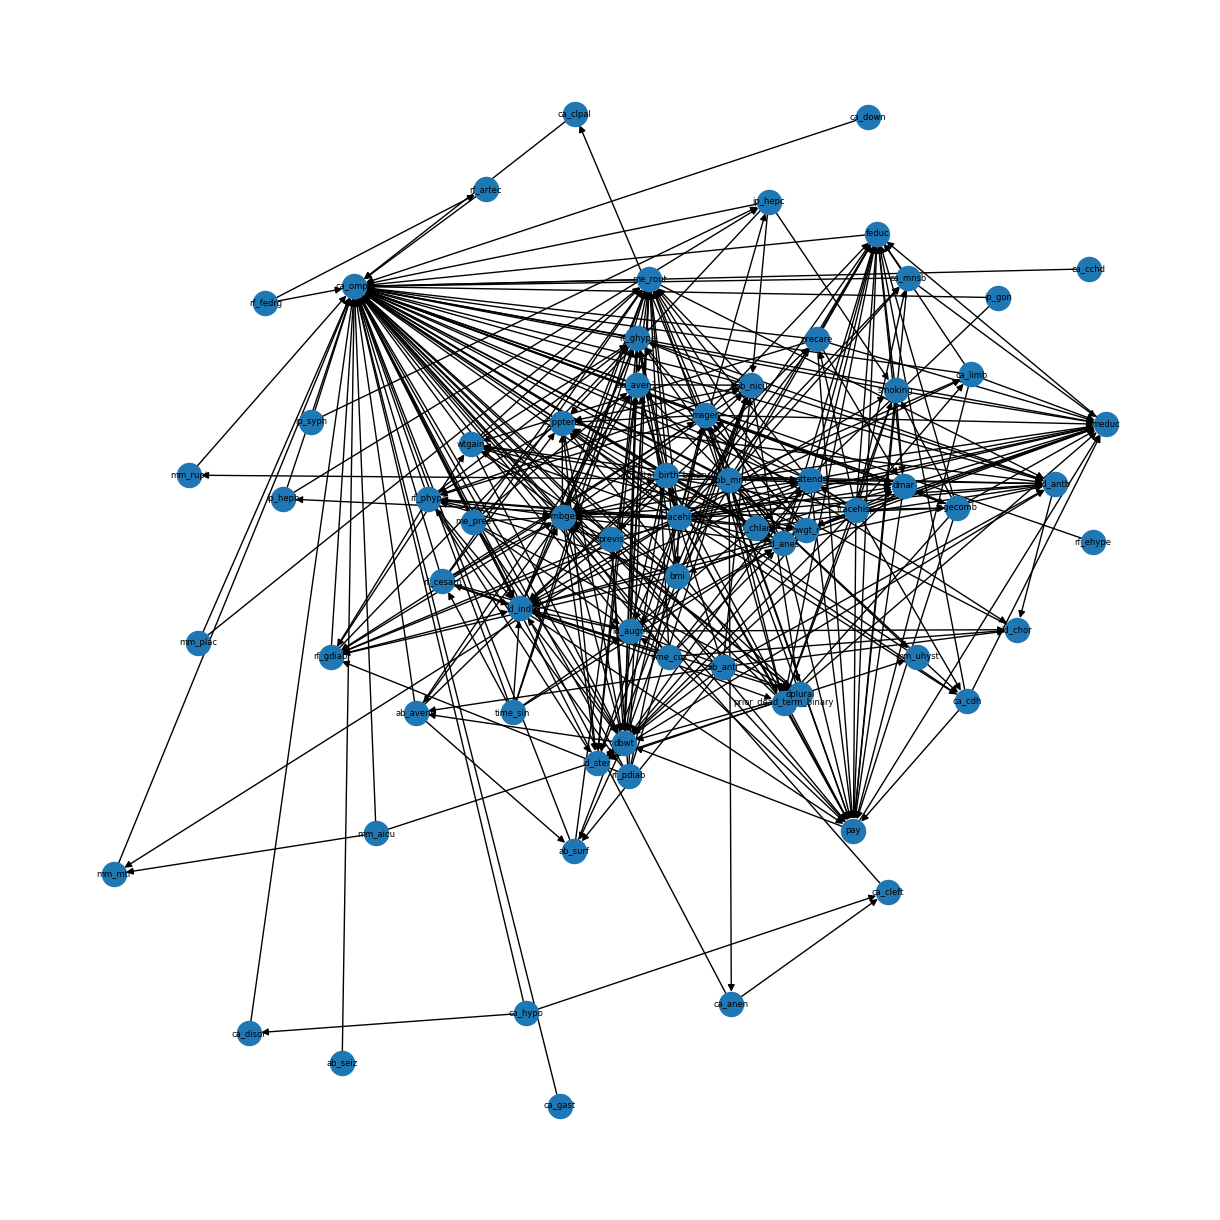

In [10]:
pydot_graph = pydot.graph_from_dot_data(searcher.get_dot())[0]
G = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.6)
nx.draw(G, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

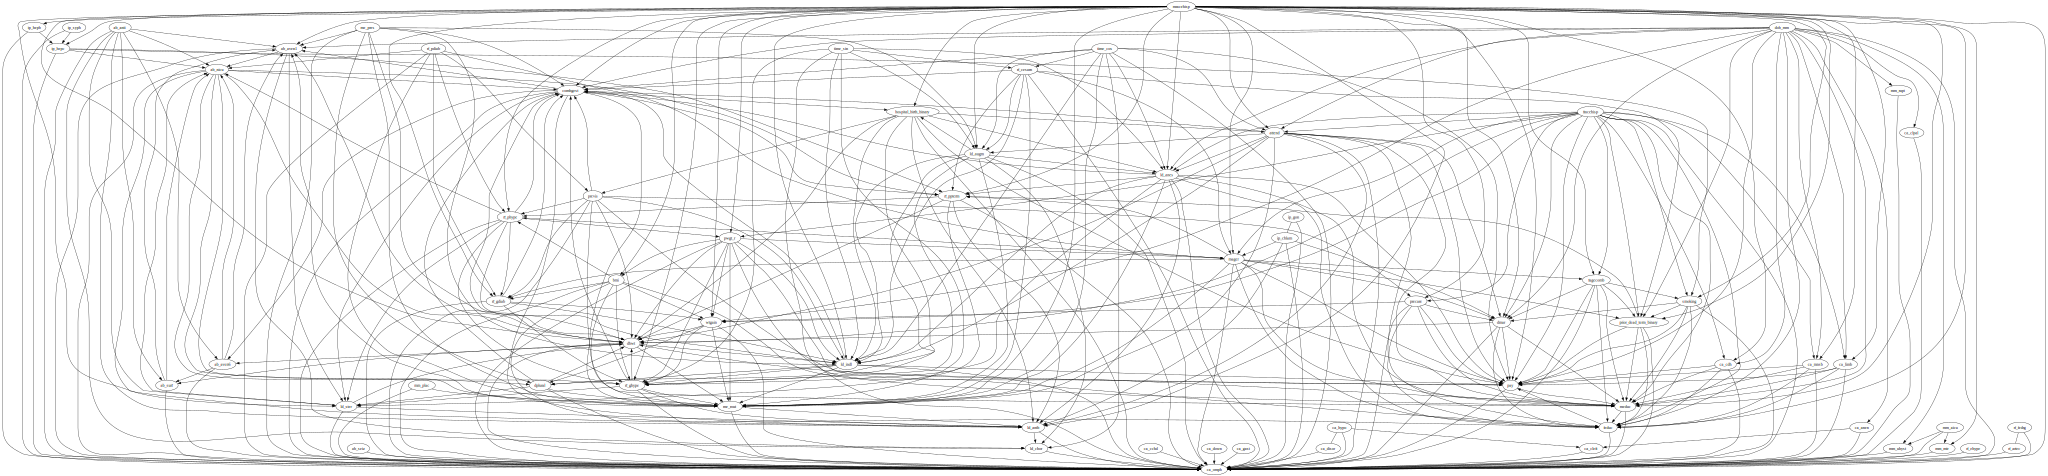

In [11]:
Source(searcher.get_dot())

<h2>PC Stable - Lower P Value</h2>

In [12]:
searcher2 = TetradSearch(X)
searcher2.add_to_tier(0, 'mracehisp')
searcher2.add_to_tier(0, 'fracehisp')
searcher2.add_to_tier(0, 'time_cos')
searcher2.add_to_tier(0, 'time_sin')
searcher2.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher2.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher2.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher2.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher2.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher2.set_forbidden(v, 'time_sin')

In [13]:
searcher2.use_g_square(alpha=0.01) 

In [14]:
searcher2.run_pc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1}, 3={0=0, 1=1}, 4={0=0, 1=1}, 5={0=0, 1=1}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 13={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 14={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 15={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 16={0=0, 1=1, 2=2}, 17={0=0, 1=1, 2=2}, 18={0=0, 1=1, 2=2}, 19={0=0, 1=1, 2=2}, 20={0=0, 1=1, 2=2}, 21={0=0, 1=1, 2=2}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3}, 24={0=0, 1=1, 2=2}, 25={0=0, 1=1, 2=2}, 26={0=0, 1=1, 2=2}, 27={0=0, 1=1, 2=2}, 28={0=0, 1=1, 2=2}, 29={0=0, 1=1, 2=2}, 30={0=0, 1=1, 2=2}, 31={0=0, 1=1, 2=2}, 32={0=0, 1=1, 2=2}, 33={0=0, 1=1, 2=2}, 34={0=0, 1=1, 2=2}, 35={0=0, 1=1, 2=2, 3=3}, 36={0=0, 1=1, 2=2, 3=3, 4=4}, 37={0=0, 1=1, 2=2}, 38={0=0, 1=1, 2=2}, 39={0=0, 1=1, 2=2}, 40={0=0, 1=1, 2=2}, 41={0=0, 1=1, 2=2}, 42={0=0, 1=1, 2=2, 3=3, 4=4}, 43={0=0, 1=1, 2=2, 3

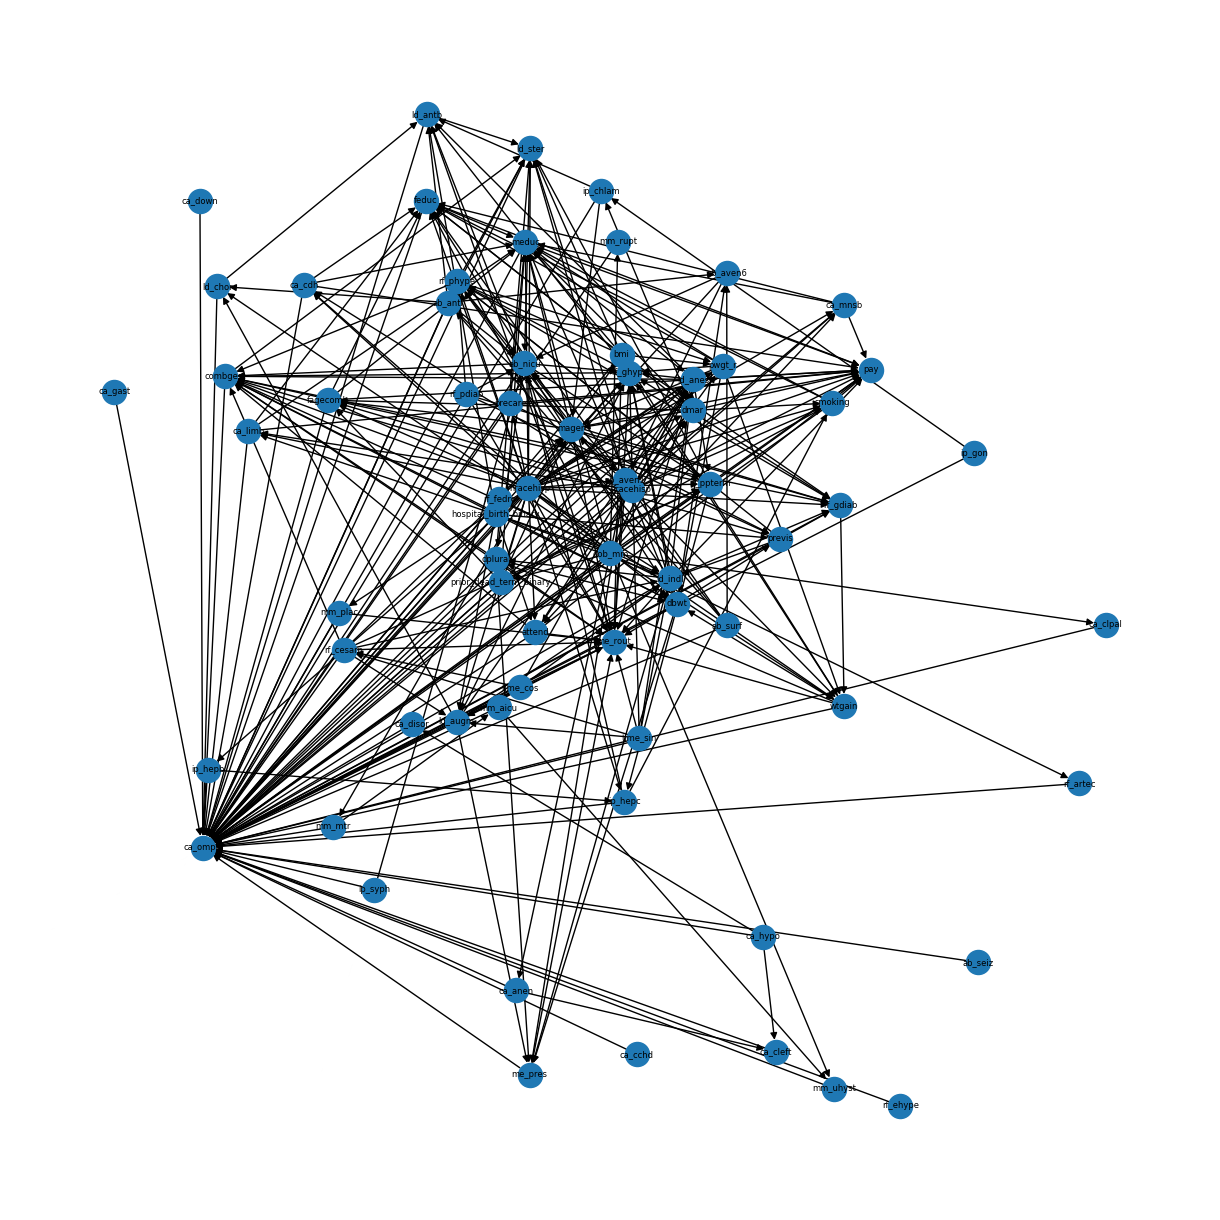

In [15]:
pydot_graph2 = pydot.graph_from_dot_data(searcher2.get_dot())[0]
G2 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph2))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G2, k=0.6)
nx.draw(G2, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

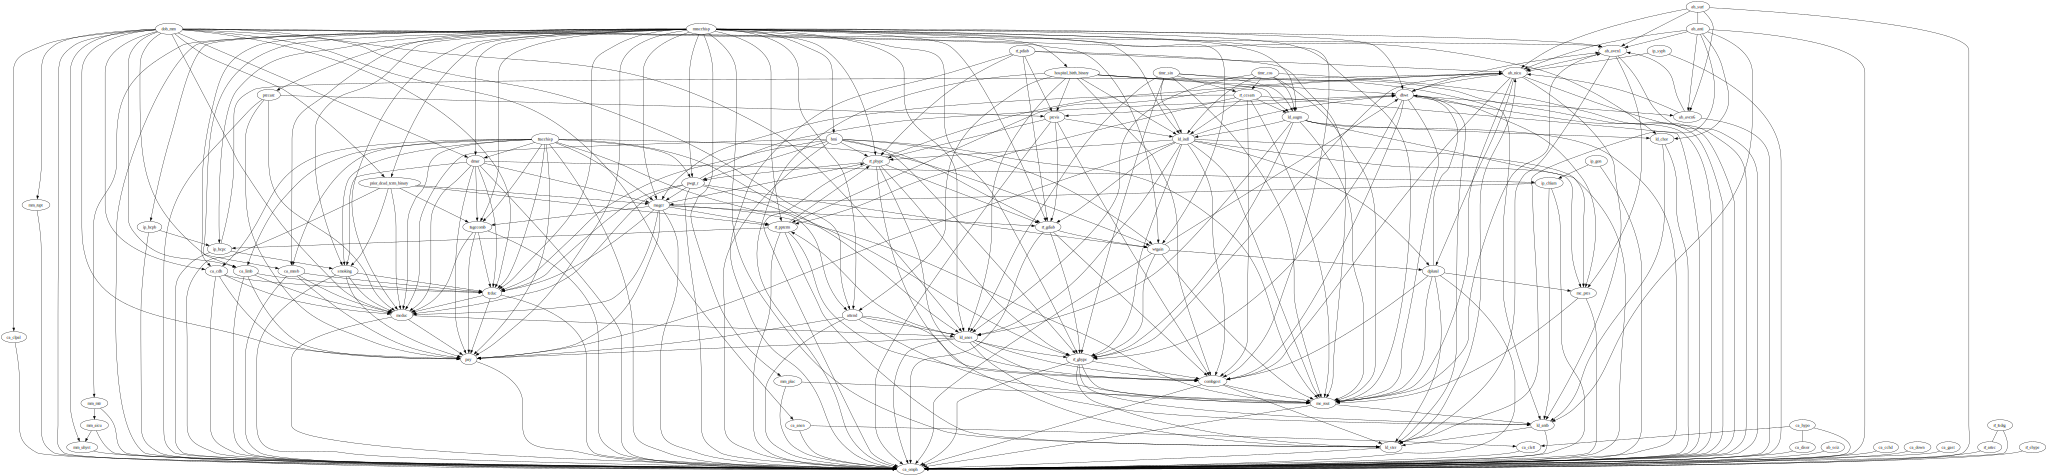

In [16]:
Source(searcher2.get_dot())

<h2>CPC</h2>

In [17]:
searcher3 = TetradSearch(X)
searcher3.add_to_tier(0, 'mracehisp')
searcher3.add_to_tier(0, 'fracehisp')
searcher3.add_to_tier(0, 'time_cos')
searcher3.add_to_tier(0, 'time_sin')
searcher3.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher3.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher3.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher3.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher3.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher3.set_forbidden(v, 'time_sin')

In [18]:
searcher3.use_g_square(alpha=0.05)
searcher3.run_cpc(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1}, 3={0=0, 1=1}, 4={0=0, 1=1}, 5={0=0, 1=1}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 13={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 14={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 15={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 16={0=0, 1=1, 2=2}, 17={0=0, 1=1, 2=2}, 18={0=0, 1=1, 2=2}, 19={0=0, 1=1, 2=2}, 20={0=0, 1=1, 2=2}, 21={0=0, 1=1, 2=2}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3}, 24={0=0, 1=1, 2=2}, 25={0=0, 1=1, 2=2}, 26={0=0, 1=1, 2=2}, 27={0=0, 1=1, 2=2}, 28={0=0, 1=1, 2=2}, 29={0=0, 1=1, 2=2}, 30={0=0, 1=1, 2=2}, 31={0=0, 1=1, 2=2}, 32={0=0, 1=1, 2=2}, 33={0=0, 1=1, 2=2}, 34={0=0, 1=1, 2=2}, 35={0=0, 1=1, 2=2, 3=3}, 36={0=0, 1=1, 2=2, 3=3, 4=4}, 37={0=0, 1=1, 2=2}, 38={0=0, 1=1, 2=2}, 39={0=0, 1=1, 2=2}, 40={0=0, 1=1, 2=2}, 41={0=0, 1=1, 2=2}, 42={0=0, 1=1, 2=2, 3=3, 4=4}, 43={0=0, 1=1, 2=2, 3

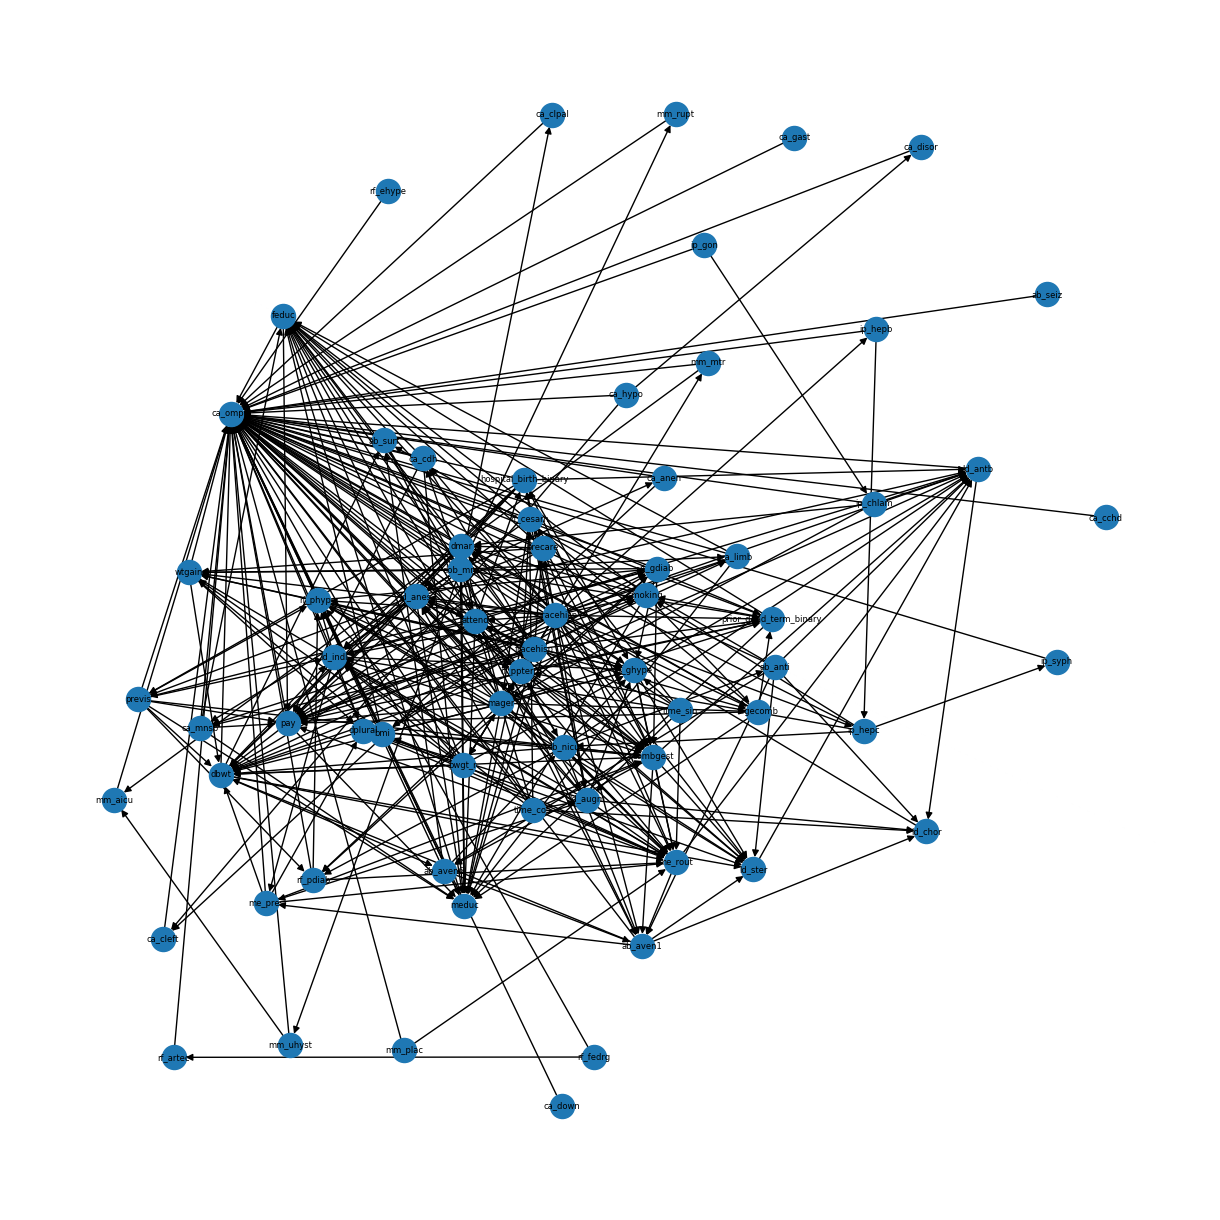

In [19]:
pydot_graph3 = pydot.graph_from_dot_data(searcher3.get_dot())[0]
G3 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph3))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G3, k=0.6)
nx.draw(G3, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

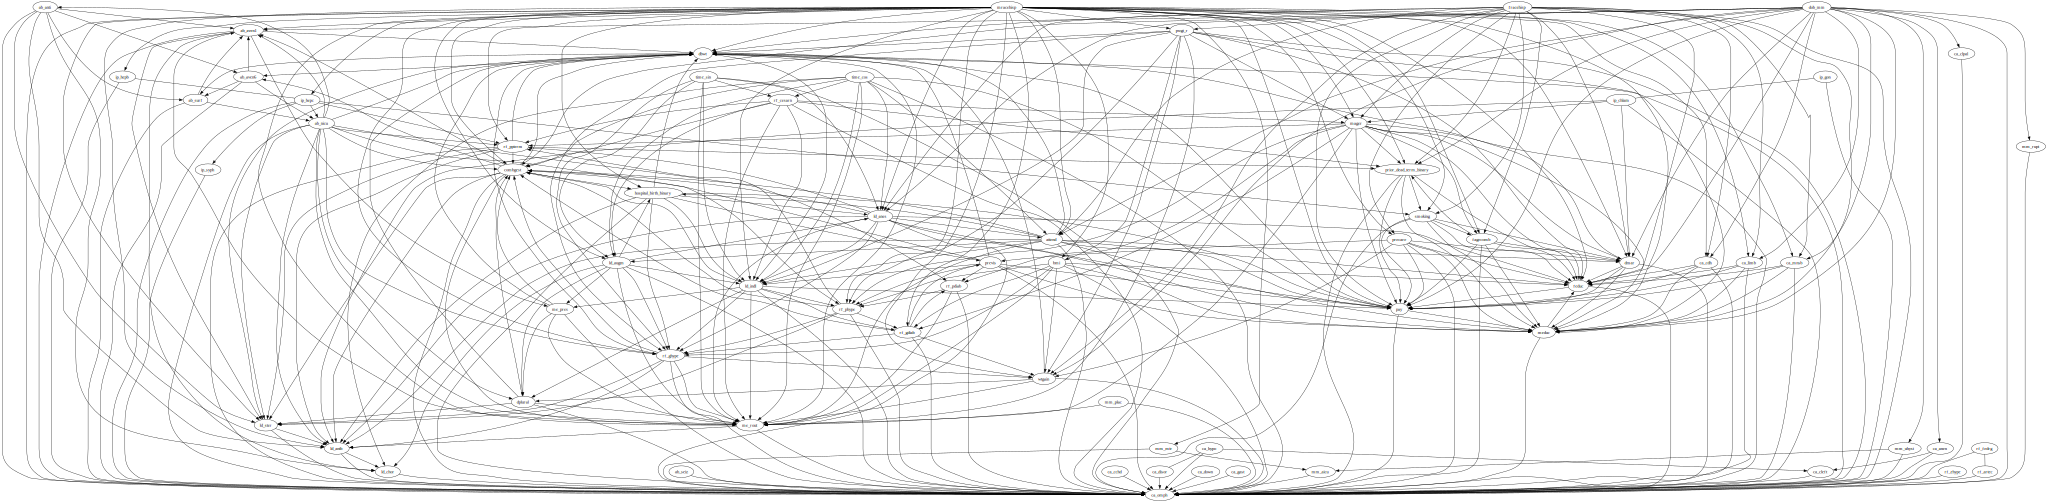

In [20]:
Source(searcher3.get_dot())

<h2>PC-Max</h2>

In [21]:
searcher4 = TetradSearch(X)
searcher4.add_to_tier(0, 'mracehisp')
searcher4.add_to_tier(0, 'fracehisp')
searcher4.add_to_tier(0, 'time_cos')
searcher4.add_to_tier(0, 'time_sin')
searcher4.add_to_tier(0, 'dob_mm')

for v in X.columns:
    if v != 'dob_mm':
        searcher4.set_forbidden(v, 'dob_mm')

for v in X.columns:
    if v != 'mracehisp':
        searcher4.set_forbidden(v, 'mracehisp')

for v in X.columns:
    if v != 'fracehisp':
        searcher4.set_forbidden(v, 'fracehisp')

for v in X.columns:
    if v != 'time_cos':
        searcher4.set_forbidden(v, 'time_cos')

for v in X.columns:
    if v != 'time_sin':
        searcher4.set_forbidden(v, 'time_sin')

In [22]:
searcher4.use_g_square(alpha=0.05)
searcher4.run_pc_max(depth=3, stable_fas=True, allow_bidirected=False)

DiscreteBicScore: attestedCategories = {0={0=0, 1=1}, 1={0=0, 1=1}, 2={0=0, 1=1}, 3={0=0, 1=1}, 4={0=0, 1=1}, 5={0=0, 1=1}, 6={0=0, 1=1}, 7={0=0, 1=1}, 8={0=0, 1=1}, 9={0=0, 1=1}, 10={0=0, 1=1}, 11={0=0, 1=1}, 12={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7}, 13={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 14={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 15={0=0, 1=1, 2=2, 3=3, 4=4, 5=5, 6=6, 7=7, 8=8}, 16={0=0, 1=1, 2=2}, 17={0=0, 1=1, 2=2}, 18={0=0, 1=1, 2=2}, 19={0=0, 1=1, 2=2}, 20={0=0, 1=1, 2=2}, 21={0=0, 1=1, 2=2}, 22={0=0, 1=1, 2=2, 3=3}, 23={0=0, 1=1, 2=2, 3=3}, 24={0=0, 1=1, 2=2}, 25={0=0, 1=1, 2=2}, 26={0=0, 1=1, 2=2}, 27={0=0, 1=1, 2=2}, 28={0=0, 1=1, 2=2}, 29={0=0, 1=1, 2=2}, 30={0=0, 1=1, 2=2}, 31={0=0, 1=1, 2=2}, 32={0=0, 1=1, 2=2}, 33={0=0, 1=1, 2=2}, 34={0=0, 1=1, 2=2}, 35={0=0, 1=1, 2=2, 3=3}, 36={0=0, 1=1, 2=2, 3=3, 4=4}, 37={0=0, 1=1, 2=2}, 38={0=0, 1=1, 2=2}, 39={0=0, 1=1, 2=2}, 40={0=0, 1=1, 2=2}, 41={0=0, 1=1, 2=2}, 42={0=0, 1=1, 2=2, 3=3, 4=4}, 43={0=0, 1=1, 2=2, 3

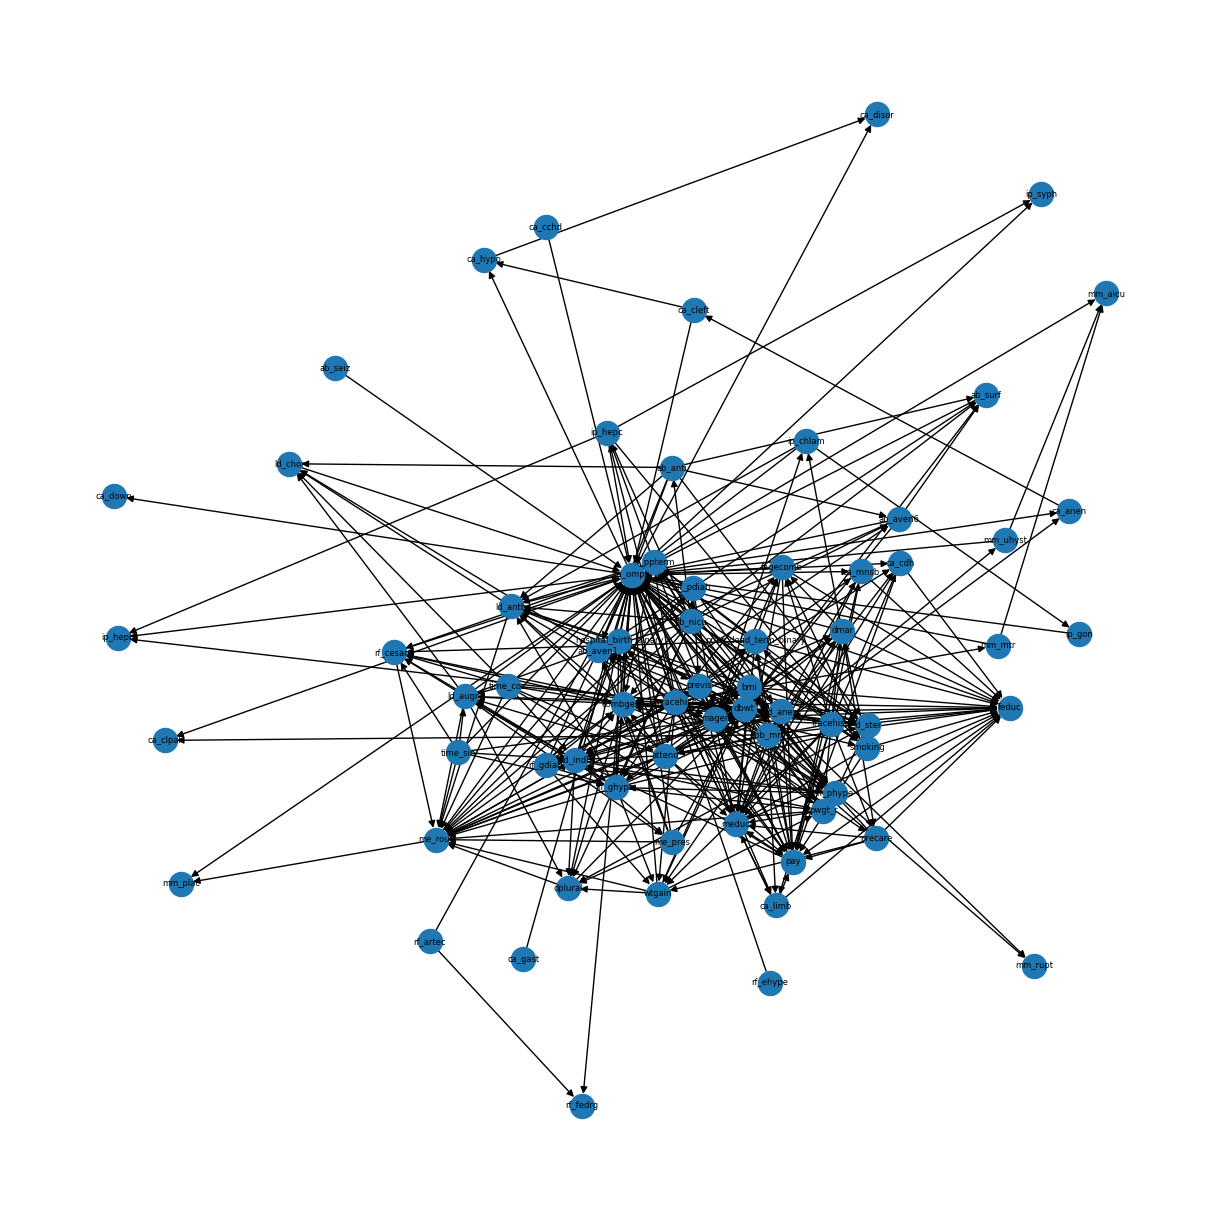

In [23]:
pydot_graph4 = pydot.graph_from_dot_data(searcher4.get_dot())[0]
G4 = nx.DiGraph(nx.nx_pydot.from_pydot(pydot_graph4))

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G4, k=0.6)
nx.draw(G4, pos, with_labels=True, font_size=6, node_size=300)
plt.show()

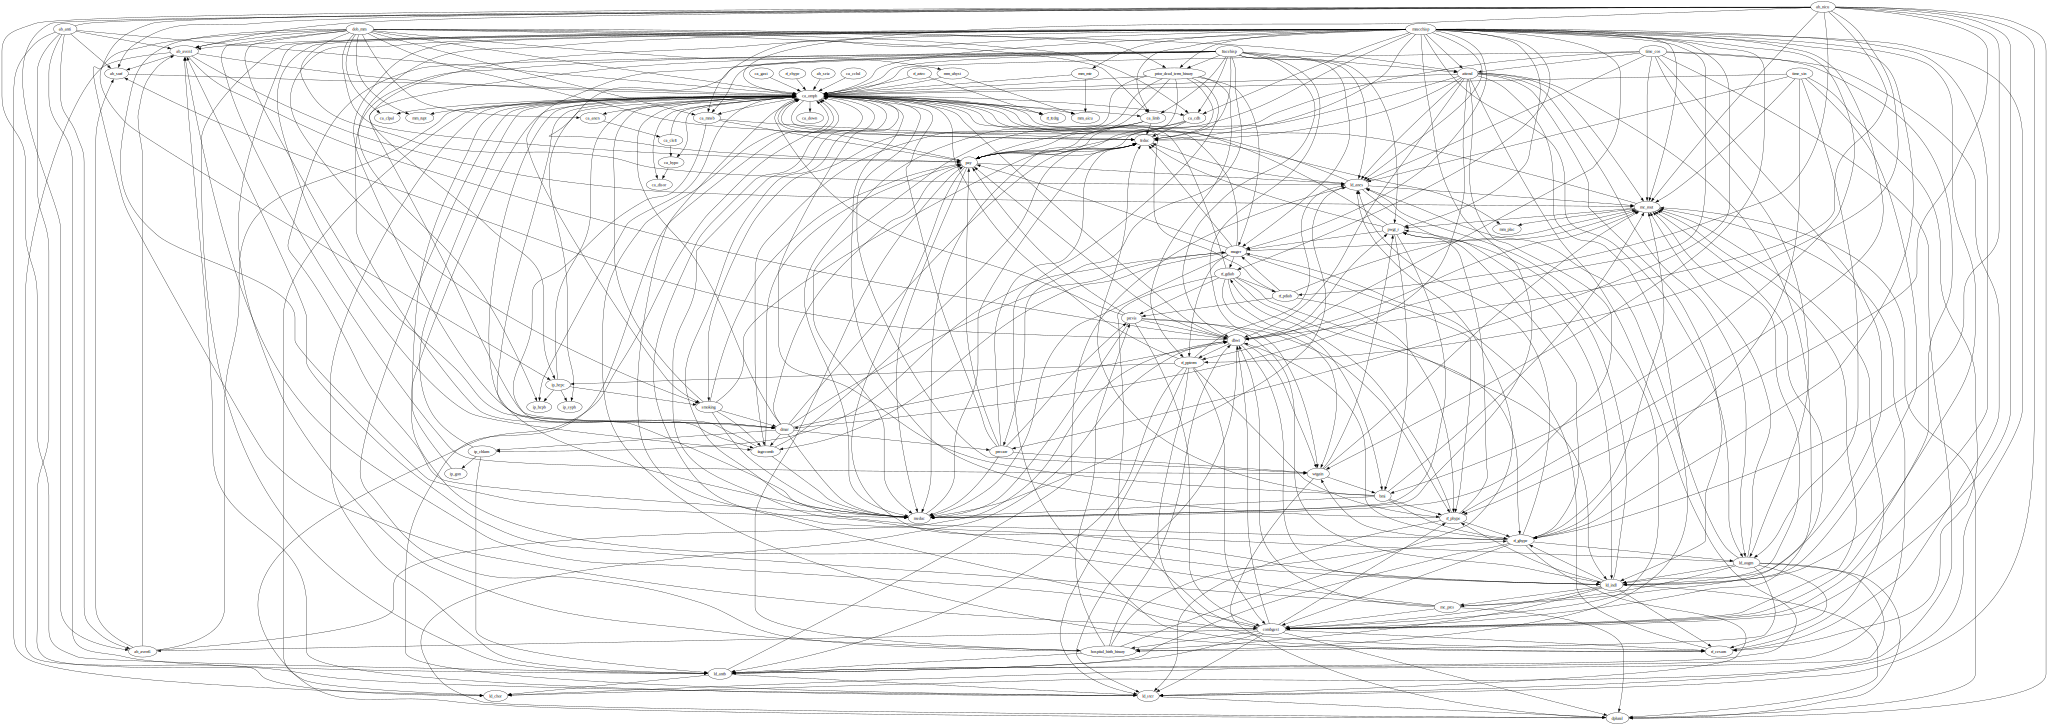

In [24]:
Source(searcher4.get_dot())